In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df_dw = pd.read_excel("dw_dominate_data/dw_dominate_house.XLSX")
df_dw = df_dw[['Congress Number', 'Party Code', '1st Dimension Coordinate', '1st Dimension Bootstrapped Standard Error']]
df_dw['Party Code'] = pd.to_numeric(df_dw['Party Code'], errors='coerce')

#filtering out other parties
#100 = Democrats,  200 = Republicans
df_dw = df_dw[df_dw['Party Code'].isin([100, 200])]

#Group by party and congress and calculate average 1_dimension
df_dw["abs_d1"] = df_dw["1st Dimension Coordinate"].abs()
party_avgs = (
    df_dw.groupby(["Congress Number", "Party Code"])          # one group = one party in one Congress
    .agg(avg_abs_d1=("abs_d1", "mean"))                  # rename the column for clarity
    .reset_index()
)

mask = party_avgs["Party Code"].eq(party_avgs["Party Code"].shift(-1))
#congress where only ona party avg is available
congress_same_party = party_avgs.loc[mask, "Congress Number"].tolist()

# keep the rows where the condition is **False**
df_kept = party_avgs.loc[~mask].reset_index(drop=True)
df_kept[df_kept["Congress Number"].between(75, 112)]

# --- Apply Party-Seat Weighting ---
df_seats_partition = pd.read_excel("dw_dominate_data/house_seats.xlsx")
df_seats_partition = df_seats_partition[["Congress Number", "# Seats", "Democrats", "Republicans"]]
df_seats_partition = df_seats_partition[df_seats_partition["Congress Number"].between(75, 112)]

# df1 and df2 each have a column called "Congress Number"
df_merged = pd.merge(
    df_kept,                       # left table
    df_seats_partition,                       # right table
    on="Congress Number",      # key column present in *both* tables
    how="inner",               # match-type: inner | left | right | outer
    suffixes=("_x", "_y")      # handles duplicate column names
)

df_merged["Weighted 1-dimension"] = np.where(
    df_merged["Party Code"] == 100,                      # condition
    df_merged["avg_abs_d1"] * df_merged["Democrats"]   / df_merged["# Seats"],   # if Democrat
    df_merged["avg_abs_d1"] * df_merged["Republicans"] / df_merged["# Seats"]    # if Republican
)

# sum the weighted scores within each (Congress, Party) pair
weighted_sum = (
    df_merged.groupby(["Congress Number"], as_index=False)
    ["Weighted 1-dimension"]
    .sum()
    .rename(columns={"Weighted 1-dimension": "weighted_sum"})
)

weighted_sum = weighted_sum.sort_values("Congress Number")

In [20]:
array_score = np.array(weighted_sum["weighted_sum"])

score_std = np.std(array_score)
score_mean = np.mean(array_score)

standard_dw_score = (array_score - score_std)/score_mean
standard_dw_score = standard_dw_score.tolist()

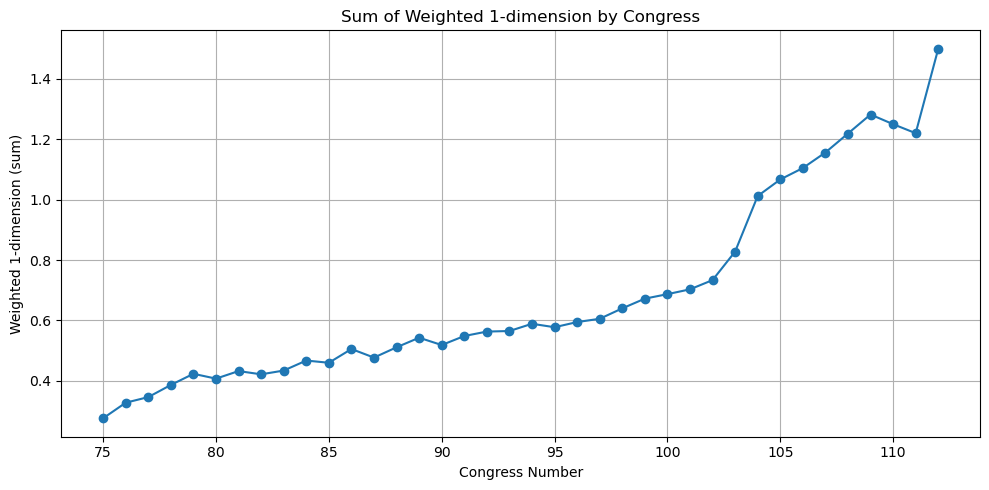

In [21]:

plt.figure(figsize=(10, 5))               # a comfortable size
plt.plot(
    weighted_sum["Congress Number"],
    standard_dw_score,
    marker="o"                            # dots help show each Congress
)                                         # (no explicit color → Matplotlib default)

plt.xlabel("Congress Number")
plt.ylabel("Weighted 1-dimension (sum)")
plt.title("Sum of Weighted 1-dimension by Congress")
plt.grid(True)                            # light background grid
plt.tight_layout()                        # tidy margins
plt.show()